# Modelos estatisticos para séries temporais

In [4]:
library(forecast)
library(tseries)
library(data.table)
library(zoo)

## Modelos Autoregressivos (AR)

Toma como base a intuição de que o passado prediz o futuro. Desse modo, ele pressupoe um processo de série temporal no qual o valor em um ponto no tempo $t$ é uma função dos valores da série em pontos anteriores no tempo.

### Escolhendo parametros para um modelo $AR(p)$

Para verificar a adequabilidade de uma modelo $AR$ em seus dados começe plotando o processo e sua PACF


In [5]:
data = fread('dataset//Daily_Demand_Forecasting_Orders.csv')

In [7]:
head(data, 2)

V1,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
0,1,4,316.307,223.270,61.543,175.586,302.448,0,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0,40419,21399,89461,7679,224.675


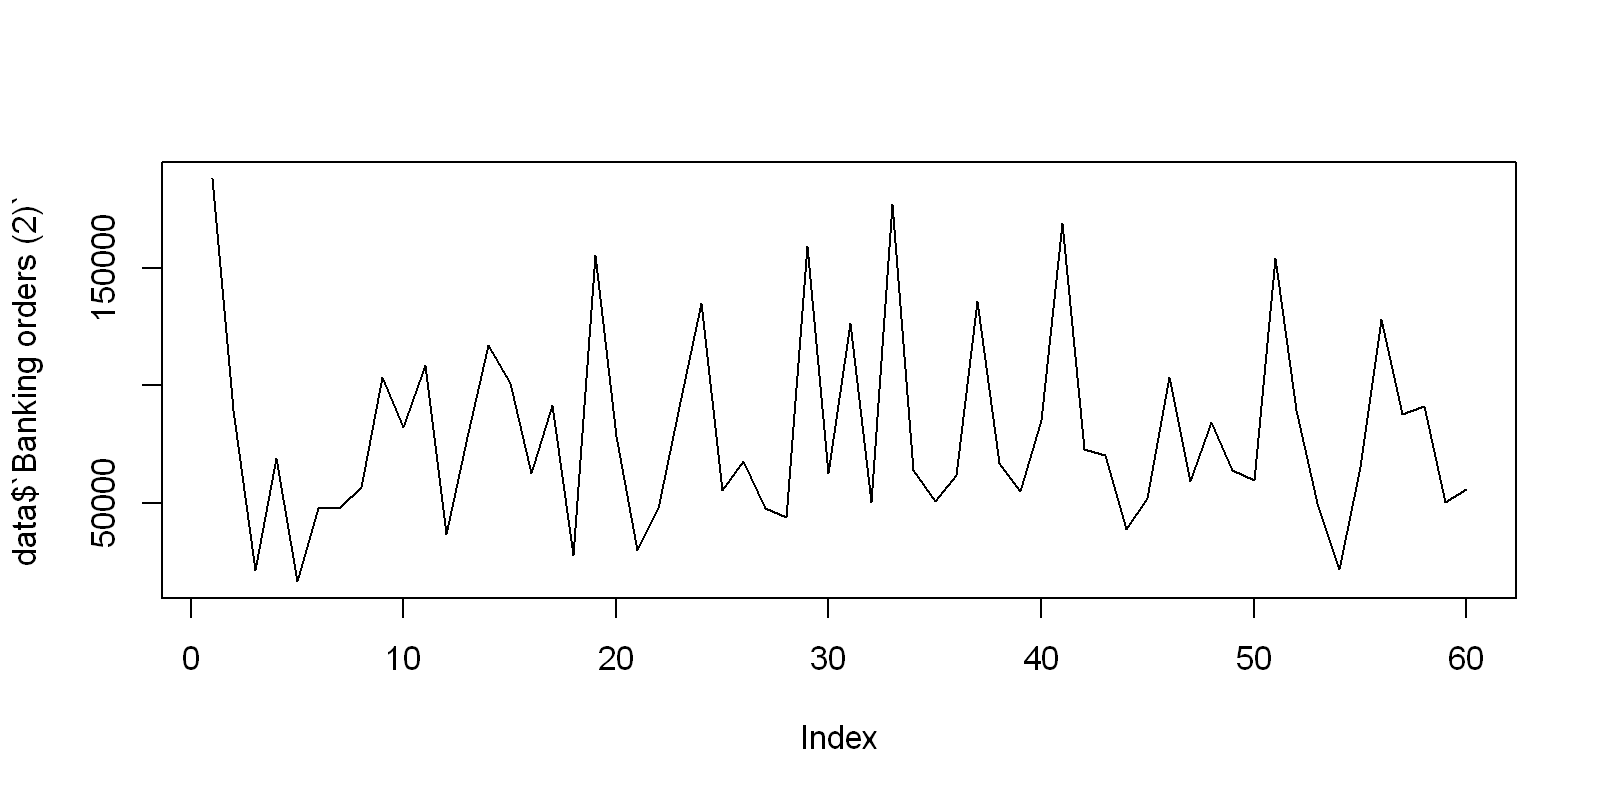

In [47]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(data$`Banking orders (2)`, type='l')

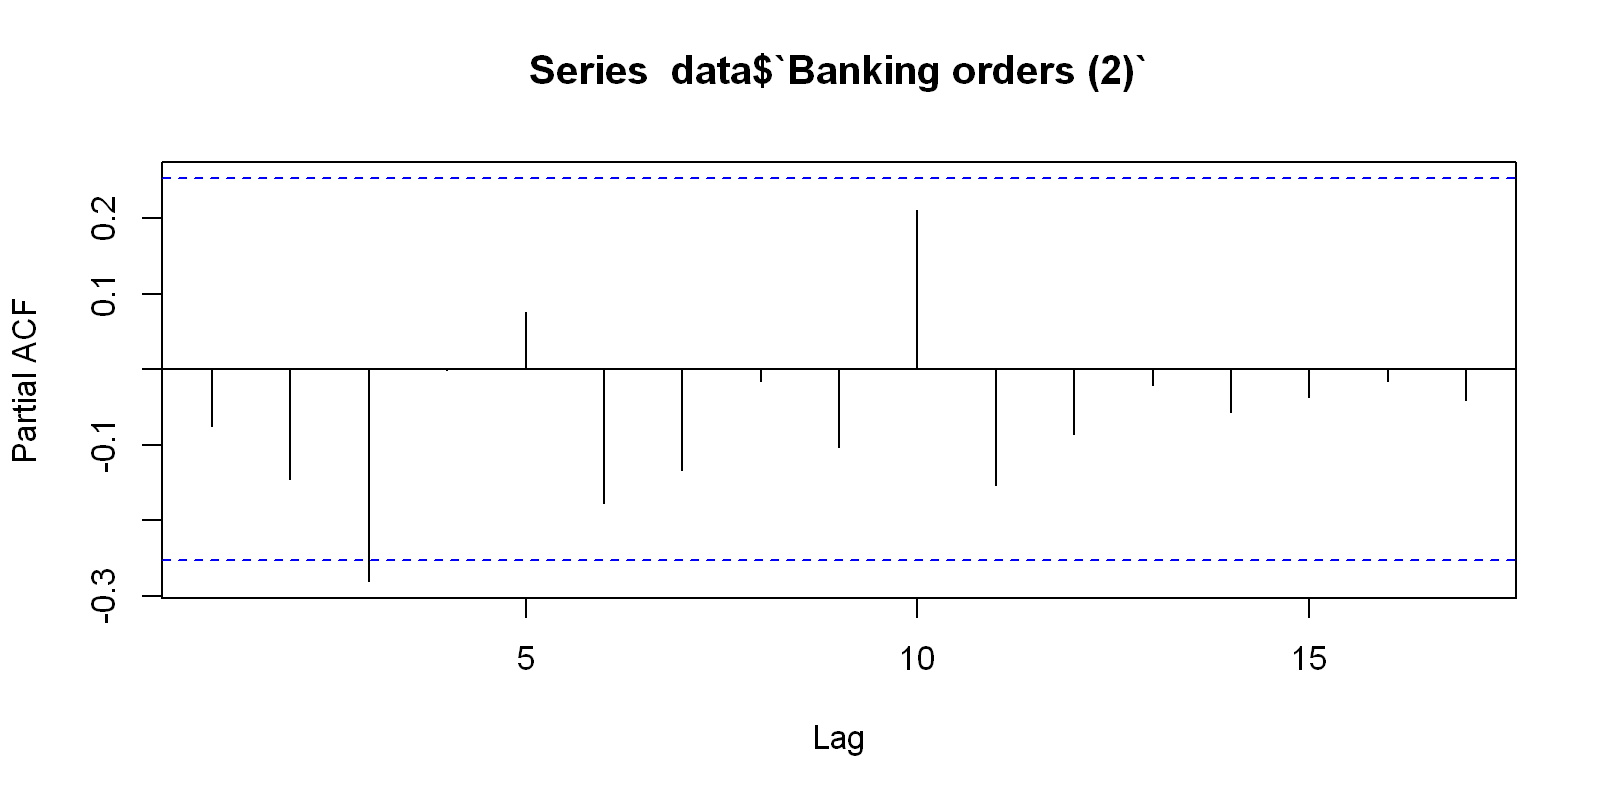

In [48]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
pacf(data$`Banking orders (2)`)

> Podemos ver que o valor que passa do limite de significancia de 5% é o lag 3.

A função `ar` do R escolhe automaticamente os parametros do modelo autoregressivo

In [15]:
fit_ar = ar(data$`Banking orders (2)`, method = 'mle')
fit_ar


Call:
ar(x = data$`Banking orders (2)`, method = "mle")

Coefficients:
      1        2        3  
-0.1360  -0.2014  -0.3175  

Order selected 3  sigma^2 estimated as  1.414e+09

Podemos restringir os coeficientes. Por exemplo, podemos se perguntar se queremos incluir um coef para o termo de lag 1 ou se devemos atribuir a esse termo um coeficiente obrigatorio de 0, dado que o seu valor está bem abaixo no limite de significancia para PACF.

Usando o arima podemos restringir 

In [17]:
fit_ar_1 = arima(data$`Banking orders (2)`, order = c(3, 0, 0))
fit_ar_1


Call:
arima(x = data$`Banking orders (2)`, order = c(3, 0, 0))

Coefficients:
          ar1      ar2      ar3  intercept
      -0.1358  -0.2013  -0.3176  79075.350
s.e.   0.1299   0.1289   0.1296   2981.124

sigma^2 estimated as 1.414e+09:  log likelihood = -717.42,  aic = 1444.83

restriningo o modelo

In [20]:
est.1 = arima(
    data$`Banking orders (2)`,
    order = c(3, 0, 0),
    fixed = c(0, NA, NA, NA)
)
est.1

Warning message in arima(data$`Banking orders (2)`, order = c(3, 0, 0), fixed = c(0, :
"Alguns parâmetros AR foram fixados: definindo transform.pars = FALSE"



Call:
arima(x = data$`Banking orders (2)`, order = c(3, 0, 0), fixed = c(0, NA, NA, 
    NA))

Coefficients:
      ar1      ar2      ar3  intercept
        0  -0.1831  -0.3031  79190.705
s.e.    0   0.1289   0.1298   3345.253

sigma^2 estimated as 1.44e+09:  log likelihood = -717.96,  aic = 1443.91

```r
fixed = c(0, NA, NA, NA)
```
Restringimos o parametro ar_1 para zero

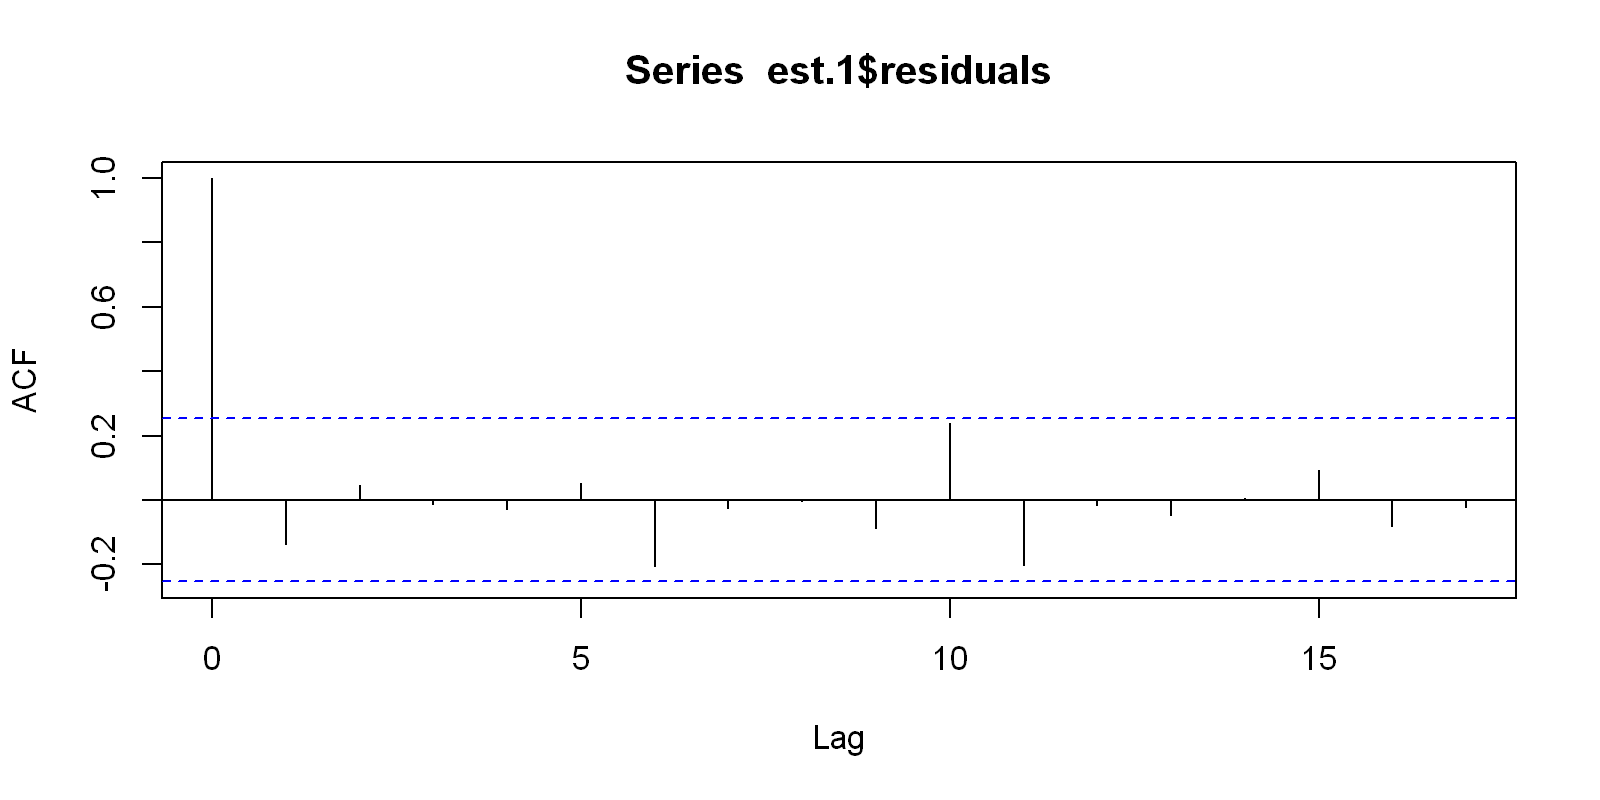

In [22]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
acf(est.1$residuals)


> Nenhum passa o threshold de significancia , contudo não devemos fechar os olhos

Outra forma de avalizar o modelo é usando o teste de Ljung-box.
$$
H_0 : \text{dados não apresenta correlação serial} \\
H_1 : \text{os dados apresentam correlação seria}
$$

In [24]:
Box.test(x = est.1$residuals, lag = 10, type = 'Ljung-Box',fitdf = 3)


	Box-Ljung test

data:  est.1$residuals
X-squared = 9.3261, df = 7, p-value = 0.2301


p_valor > 0.5, apresenta correlação serial

### Previsão

1 passo a frente

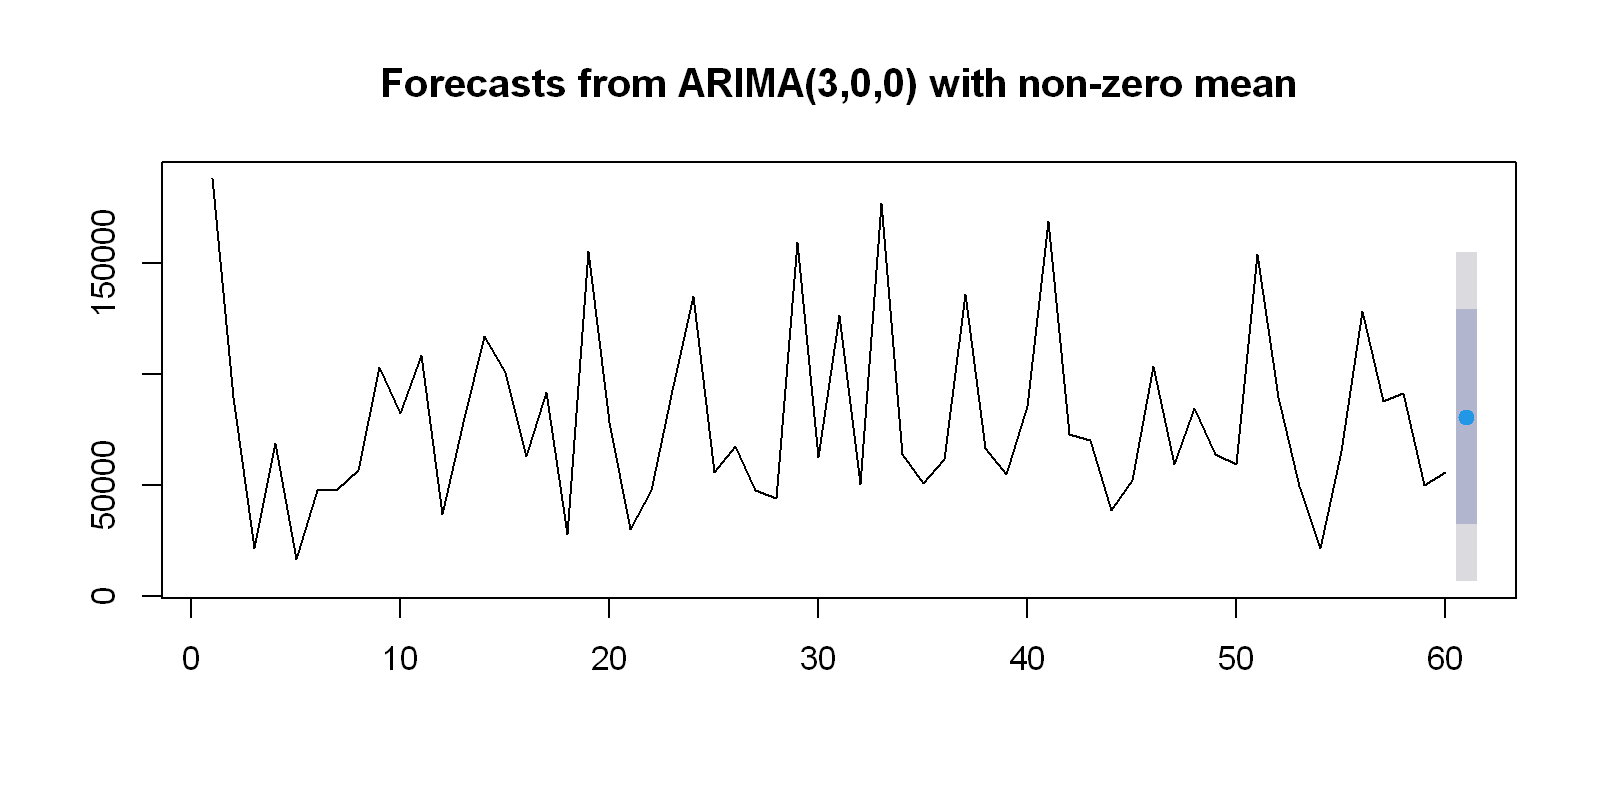

In [25]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(forecast(est.1, h = 1))

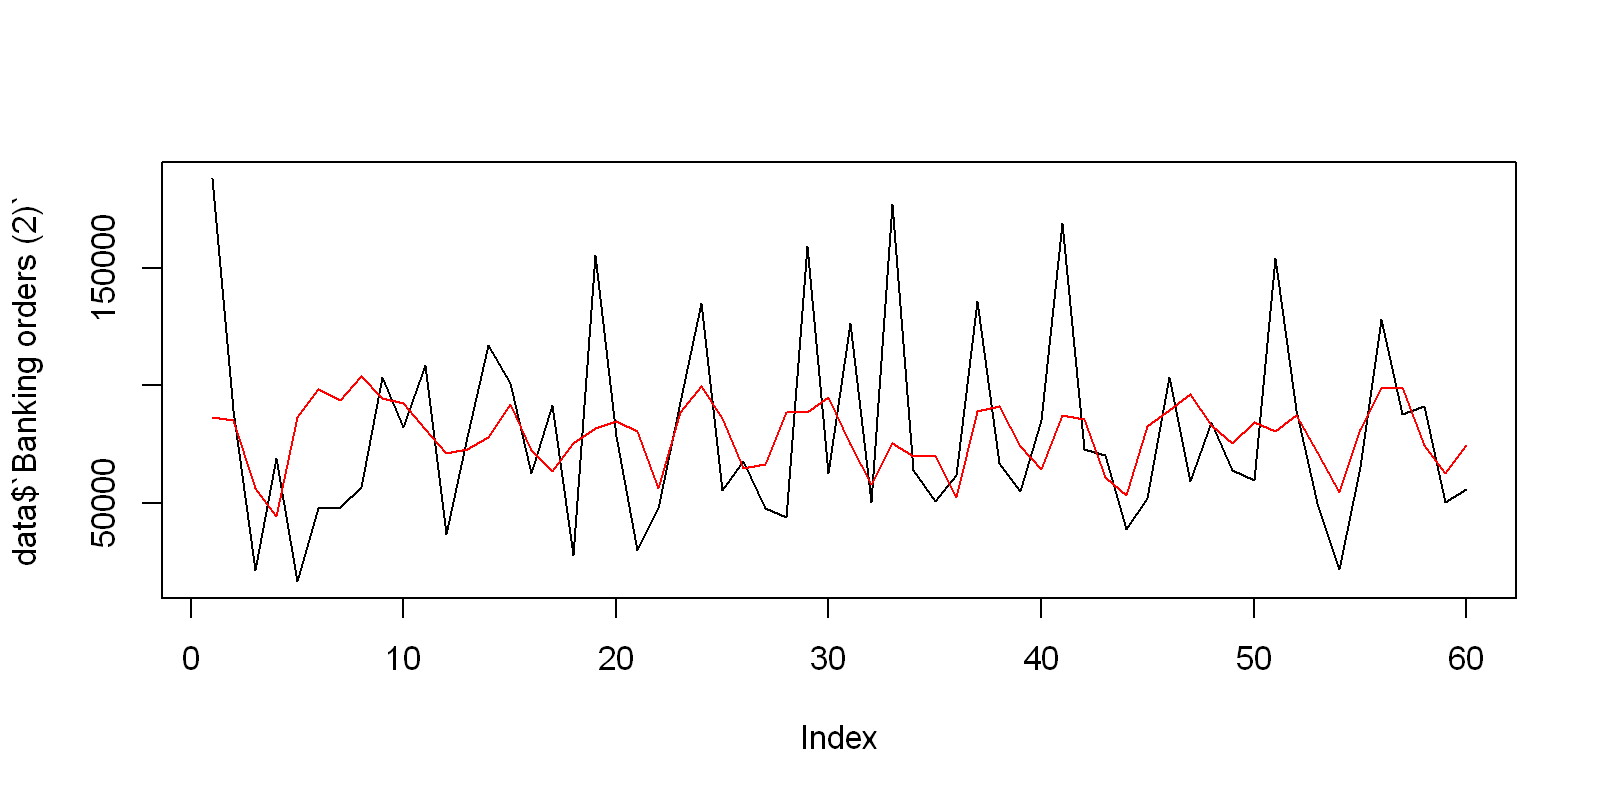

In [ ]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)

plot(data$`Banking orders (2)`, type='l')
lines(fitted(est.1), col = 'red', main = 'Previsão')

Qualidade de previsão

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


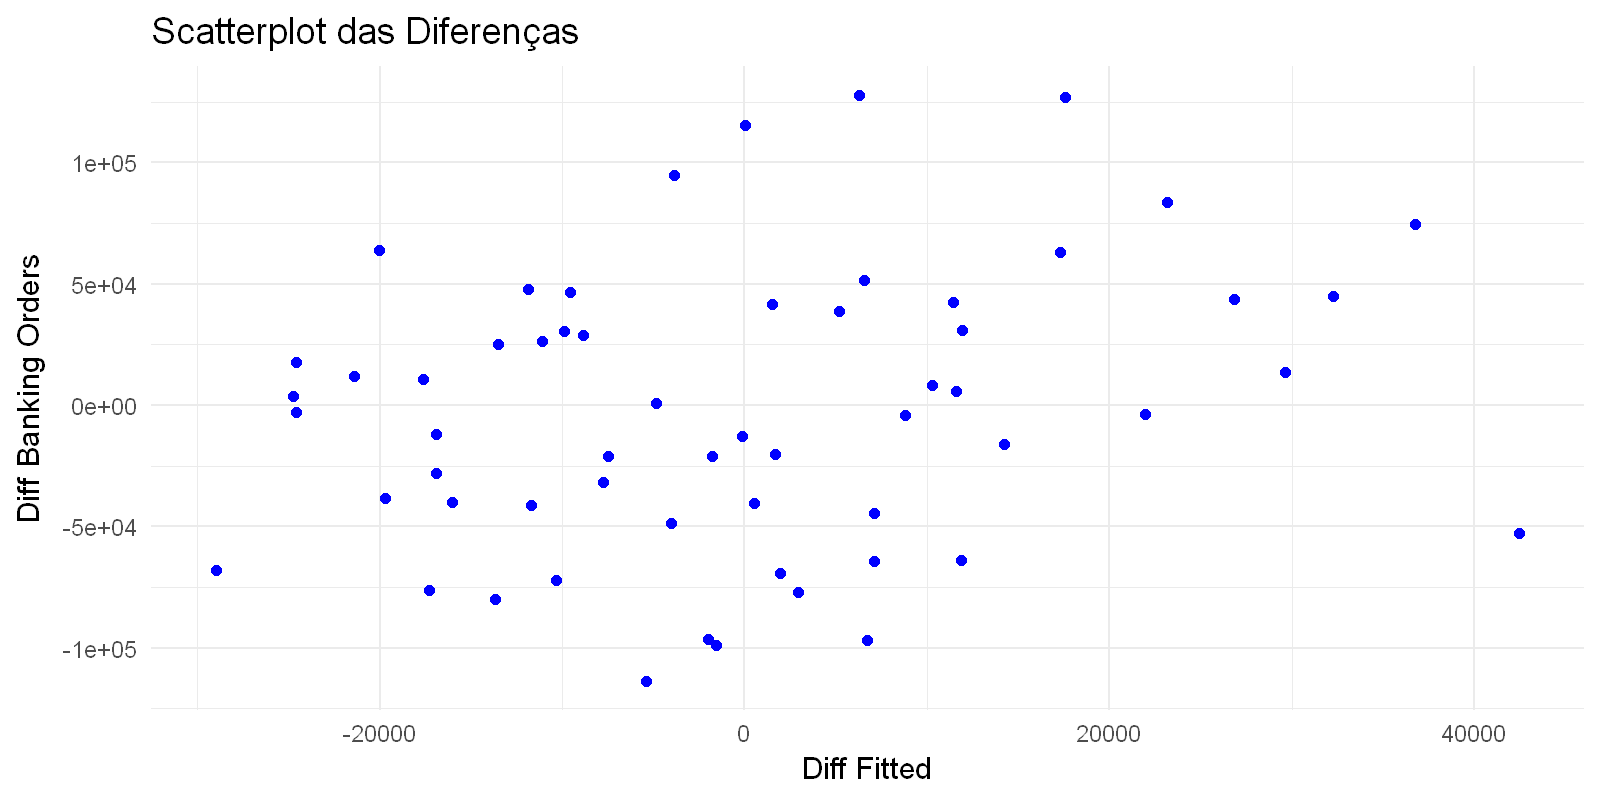

In [44]:
library(ggplot2)

df_plot <- data.frame(
  x = diff(fitted(est.1)),
  y = diff(data$`Banking orders (2)`)
)

ggplot(df_plot, aes(x = x, y = y)) +
  geom_point(color = "blue") +
  labs(
    x = "Diff Fitted",
    y = "Diff Banking Orders",
    title = "Scatterplot das Diferenças"
  ) +
  theme_minimal()


In [45]:
cor(diff(fitted(est.1)), diff(data$`Banking orders (2)`))

[1] 0.2326063

Multiplos passos a frente

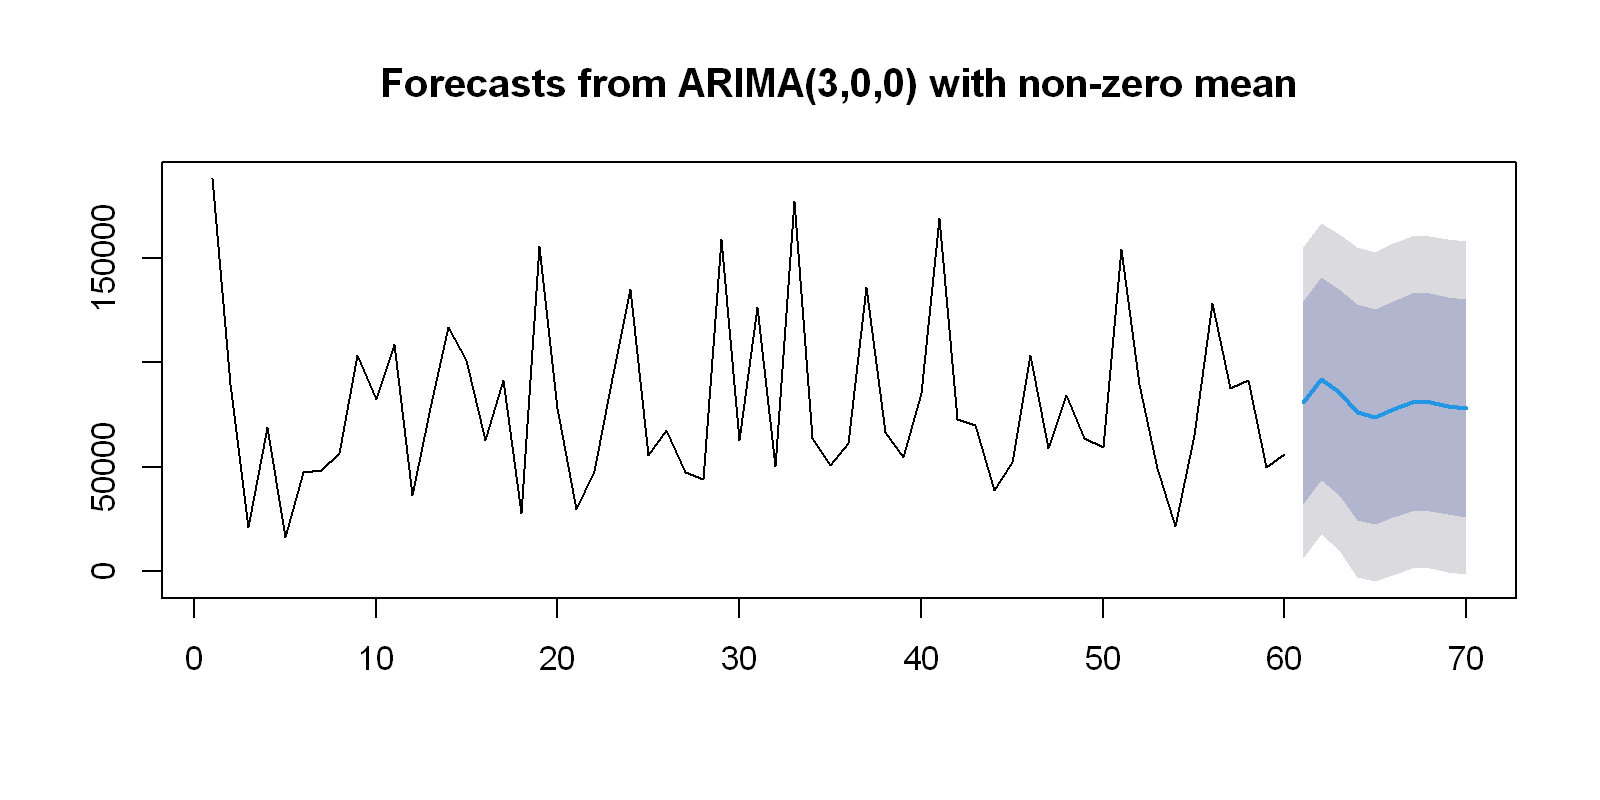

In [49]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(forecast(est.1, h = 10))

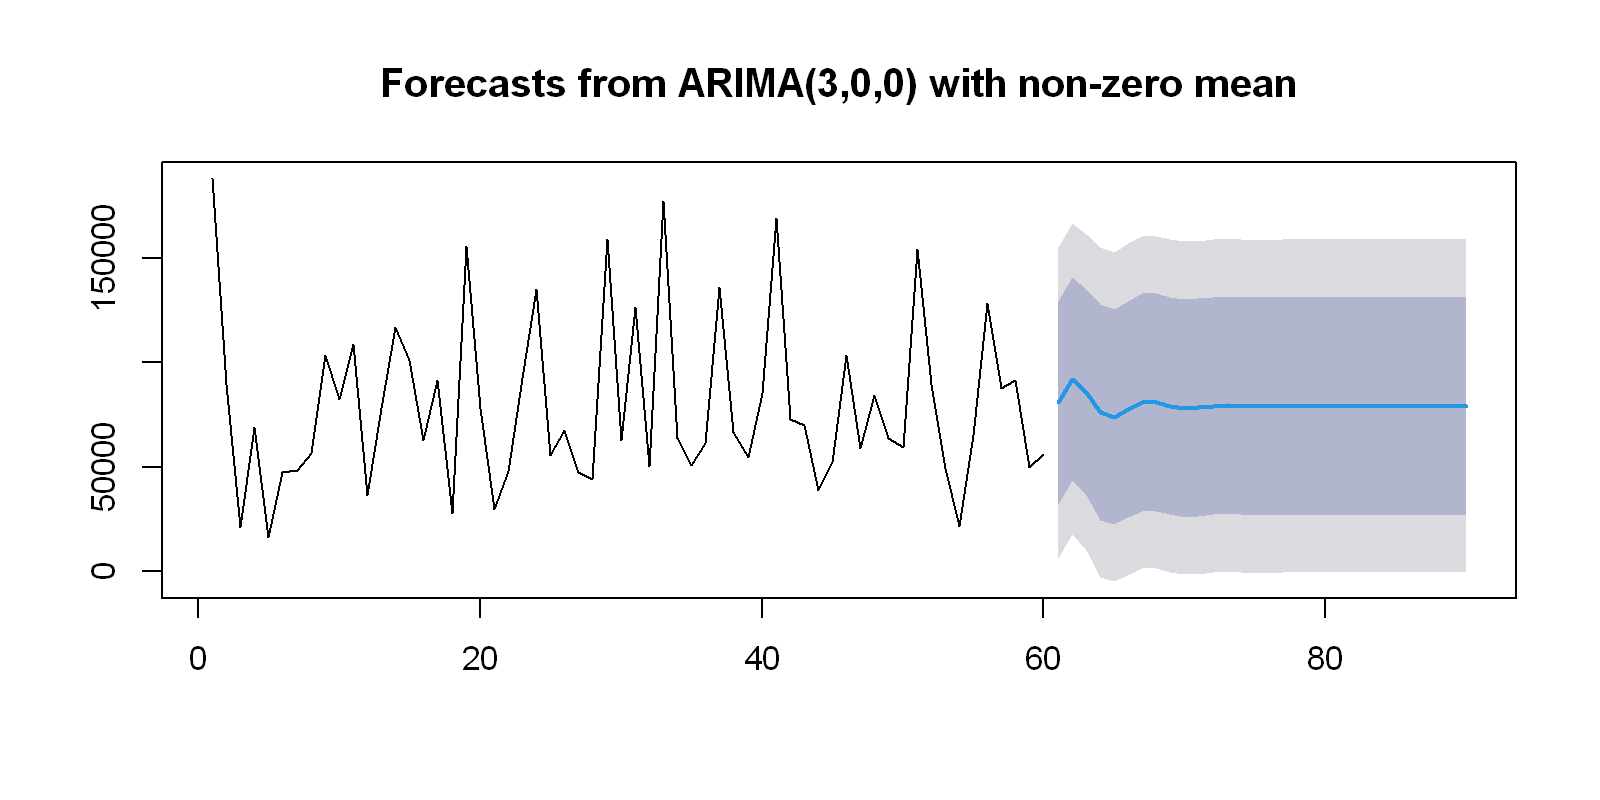

In [50]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(forecast(est.1, h = 30))

> **oS Modelos AR, ARIMA, MA, ARMA** são melhores para fazer predições de curto prazo. Quando há grande horizontes esses modelos perdem influencia preditiva.

## Modelos de Média Móvel $MA(q)$

### Escolhendo parametros para $MA(Q)$

Para ajustar o modelo MA usamos a ACF a fim de determinar a ordem do processo MA

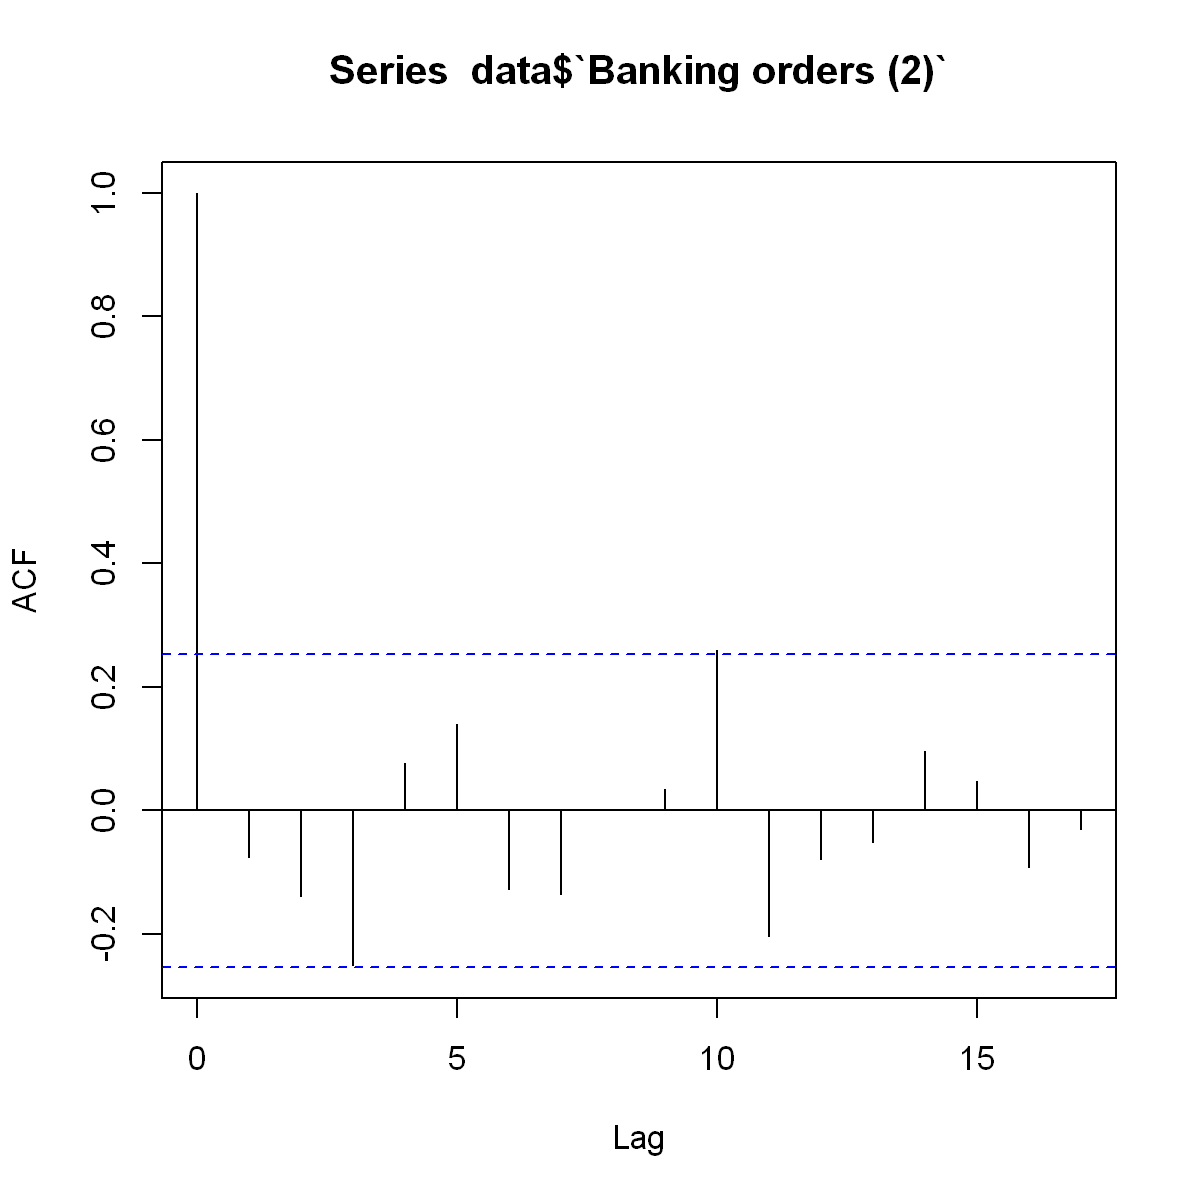

In [53]:
par(bg = 'white')
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200)
acf(data$`Banking orders (2)`)

> Lags 3 e 9 são estatiscimanets significativos

In [57]:
est.ma = arima(
    x = data$`Banking orders (2)`, 
    order = c(0, 0, 9),
    fixed = c(0, 0, NA, rep(0, 5), NA, NA)
    )
est.ma


Call:
arima(x = data$`Banking orders (2)`, order = c(0, 0, 9), fixed = c(0, 0, NA, 
    rep(0, 5), NA, NA))

Coefficients:
      ma1  ma2      ma3  ma4  ma5  ma6  ma7  ma8      ma9  intercept
        0    0  -0.4725    0    0    0    0    0  -0.0120  79689.809
s.e.    0    0   0.1459    0    0    0    0    0   0.1444   2674.593

sigma^2 estimated as 1.4e+09:  log likelihood = -717.31,  aic = 1442.61

In [58]:
Box.test(x = est.ma$residuals, lag = 10, type = 'Ljung-Box',fitdf = 3)


	Box-Ljung test

data:  est.ma$residuals
X-squared = 7.6516, df = 7, p-value = 0.3643



 1. **`x`**

* A série de resíduos ou dados que você quer testar.
* Aqui: `est.ma$residuals` → são os resíduos do modelo ajustado (`est.ma`).
* Objetivo: verificar se esses resíduos ainda apresentam autocorrelação (dependência).


2. **`lag`**

* O número máximo de defasagens (*lags*) que o teste vai considerar.
* Aqui: `lag = 10` → o teste avalia se há autocorrelação nos resíduos até a defasagem 10.
* Se os resíduos forem *ruído branco*, esperamos que não haja correlação significativa até esse lag.


 3. **`type`**

* O tipo de estatística usada:

  * `"Box-Pierce"` → versão original, menos robusta.
  * `"Ljung-Box"` → versão ajustada que melhora o desempenho em amostras pequenas.
* Aqui: `"Ljung-Box"`, que é a mais usada em séries temporais (ARIMA, MA, etc).

-

 4. **`fitdf`**

* Número de **parâmetros ajustados** no modelo.
* Esse valor é subtraído dos graus de liberdade do teste, para não superestimar a significância.
* Exemplo: se você ajustou um modelo MA(3), coloca `fitdf = 3` (número de parâmetros estimados).
* Aqui: `fitdf = 3`, provavelmente porque o seu modelo tem 3 parâmetros.

✅ **Em resumo**:
Esse comando testa a hipótese nula de que os resíduos do modelo `est.ma` são ruído branco (não autocorrelacionados) até o lag 10, levando em conta que 3 parâmetros foram ajustados.

* **H₀**: não há autocorrelação nos resíduos.
* **H₁**: há autocorrelação nos resíduos.

Se o **p-valor** < 0.05 → rejeita H₀

Se o **p-valor** ≥ 0.05 → não rejeita H₀


p_valor >= 0.05 NÃO APRESENTA CORRELAÇÃO SERIAL

### Previsão 

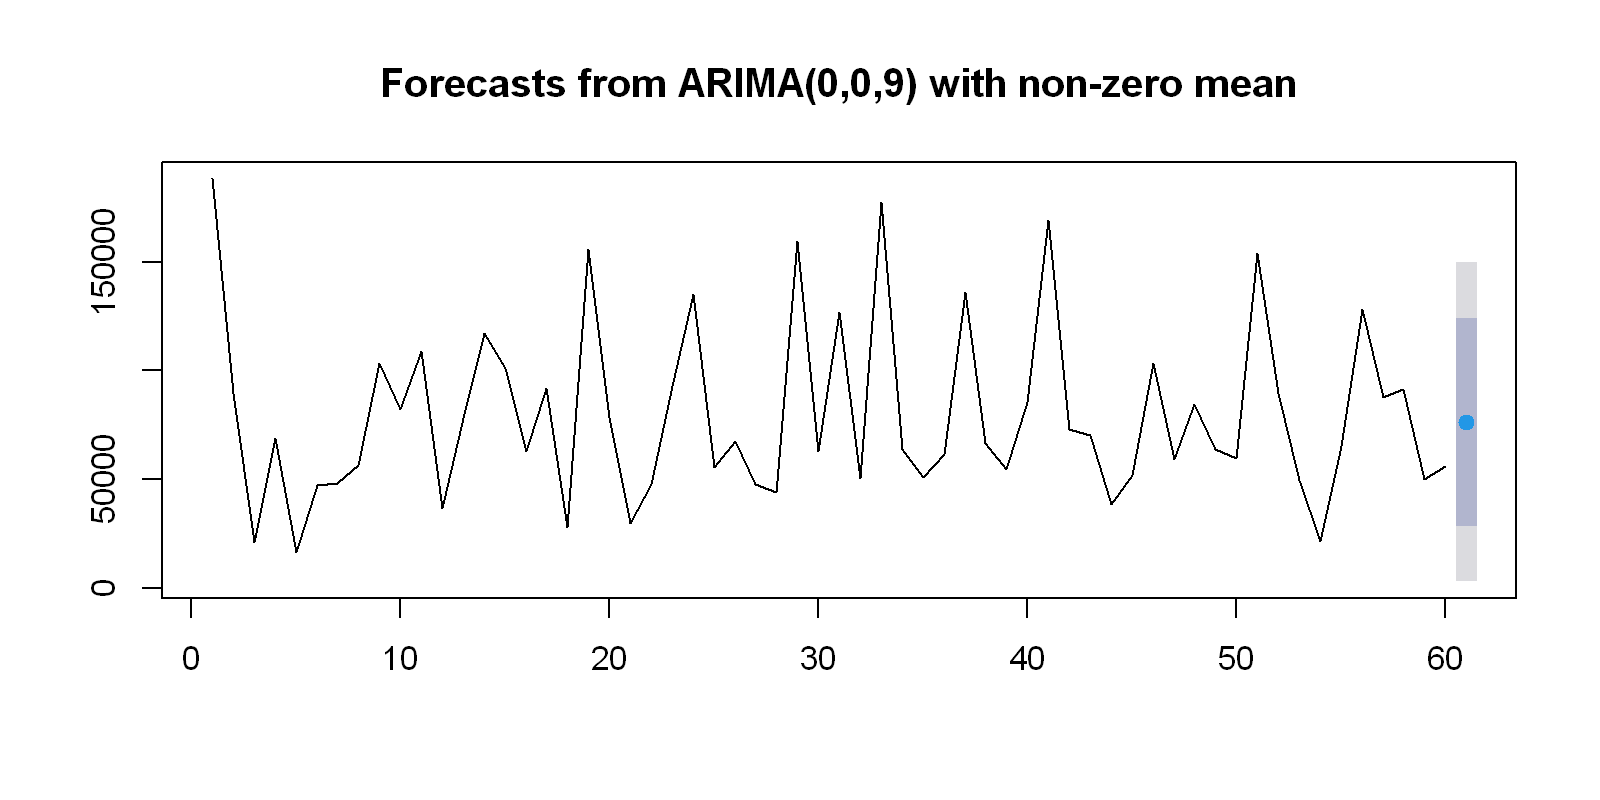

In [60]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(forecast(est.ma, h = 1))

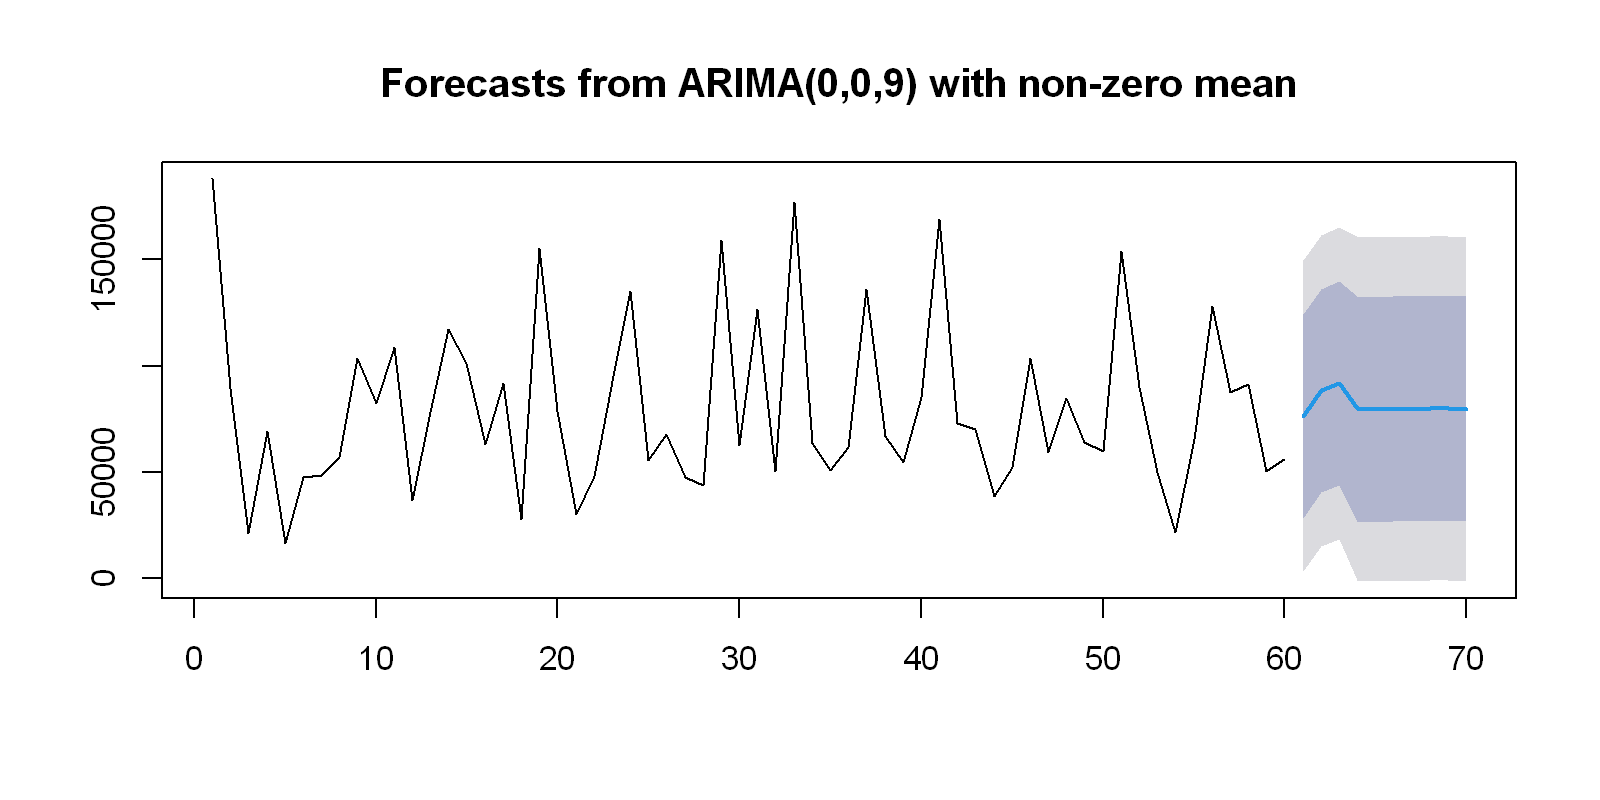

In [61]:
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(forecast(est.ma, h = 10))

> Predição a longo prazo para o modelo MA tentede a média

## Modelo Autoregressivo integrados de média movel

### Escolhendo Parametros

#### Ajustando manualmente

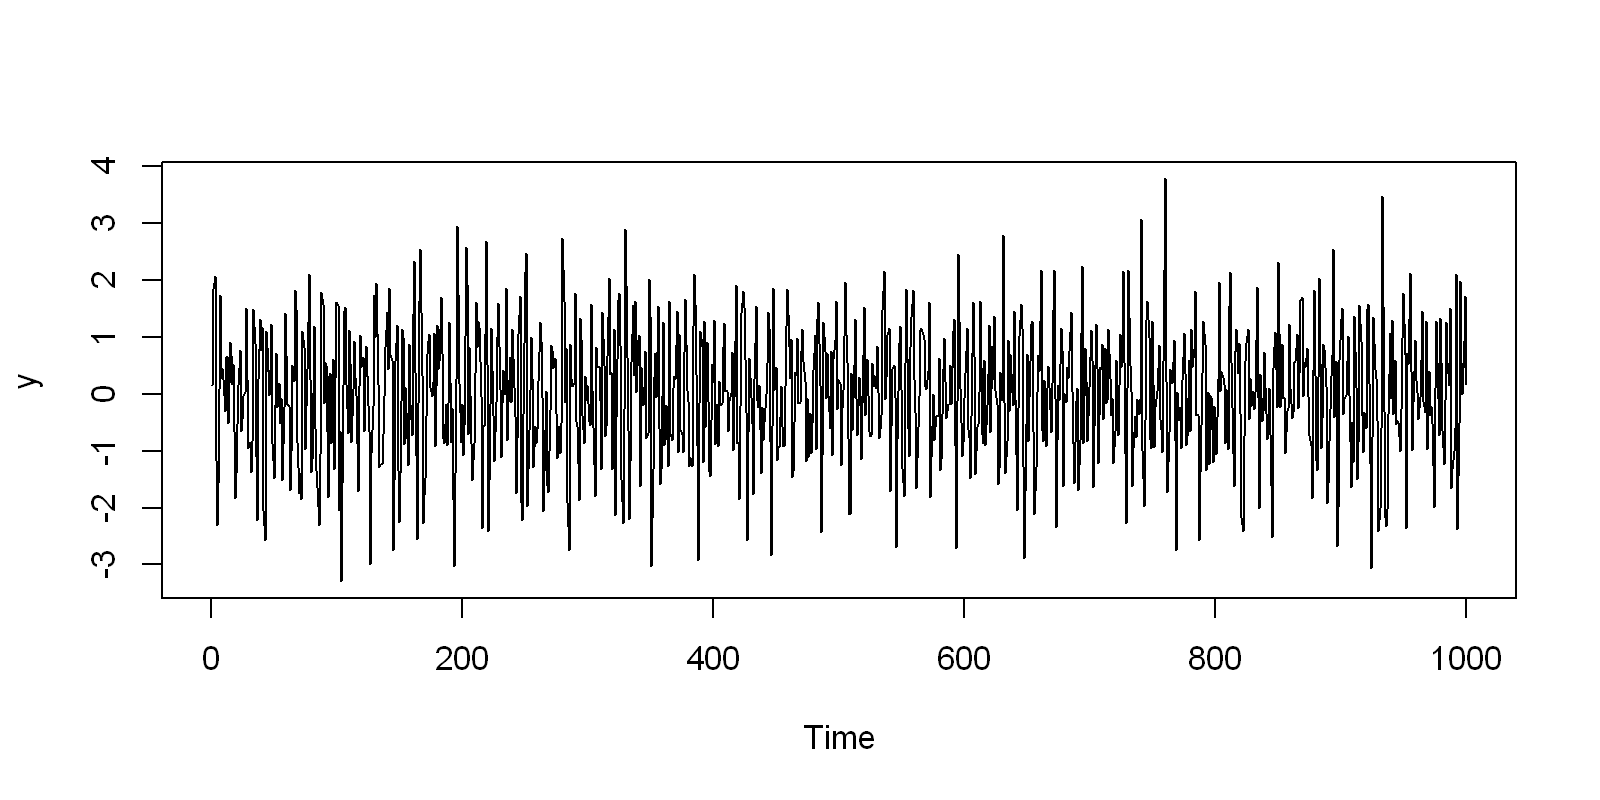

In [73]:
set.seed(1017)
y = arima.sim(n = 1000, list(ar=c(0.8, -0.4), ma=c(-0.7)))
par(bg = 'white')
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
plot(y)

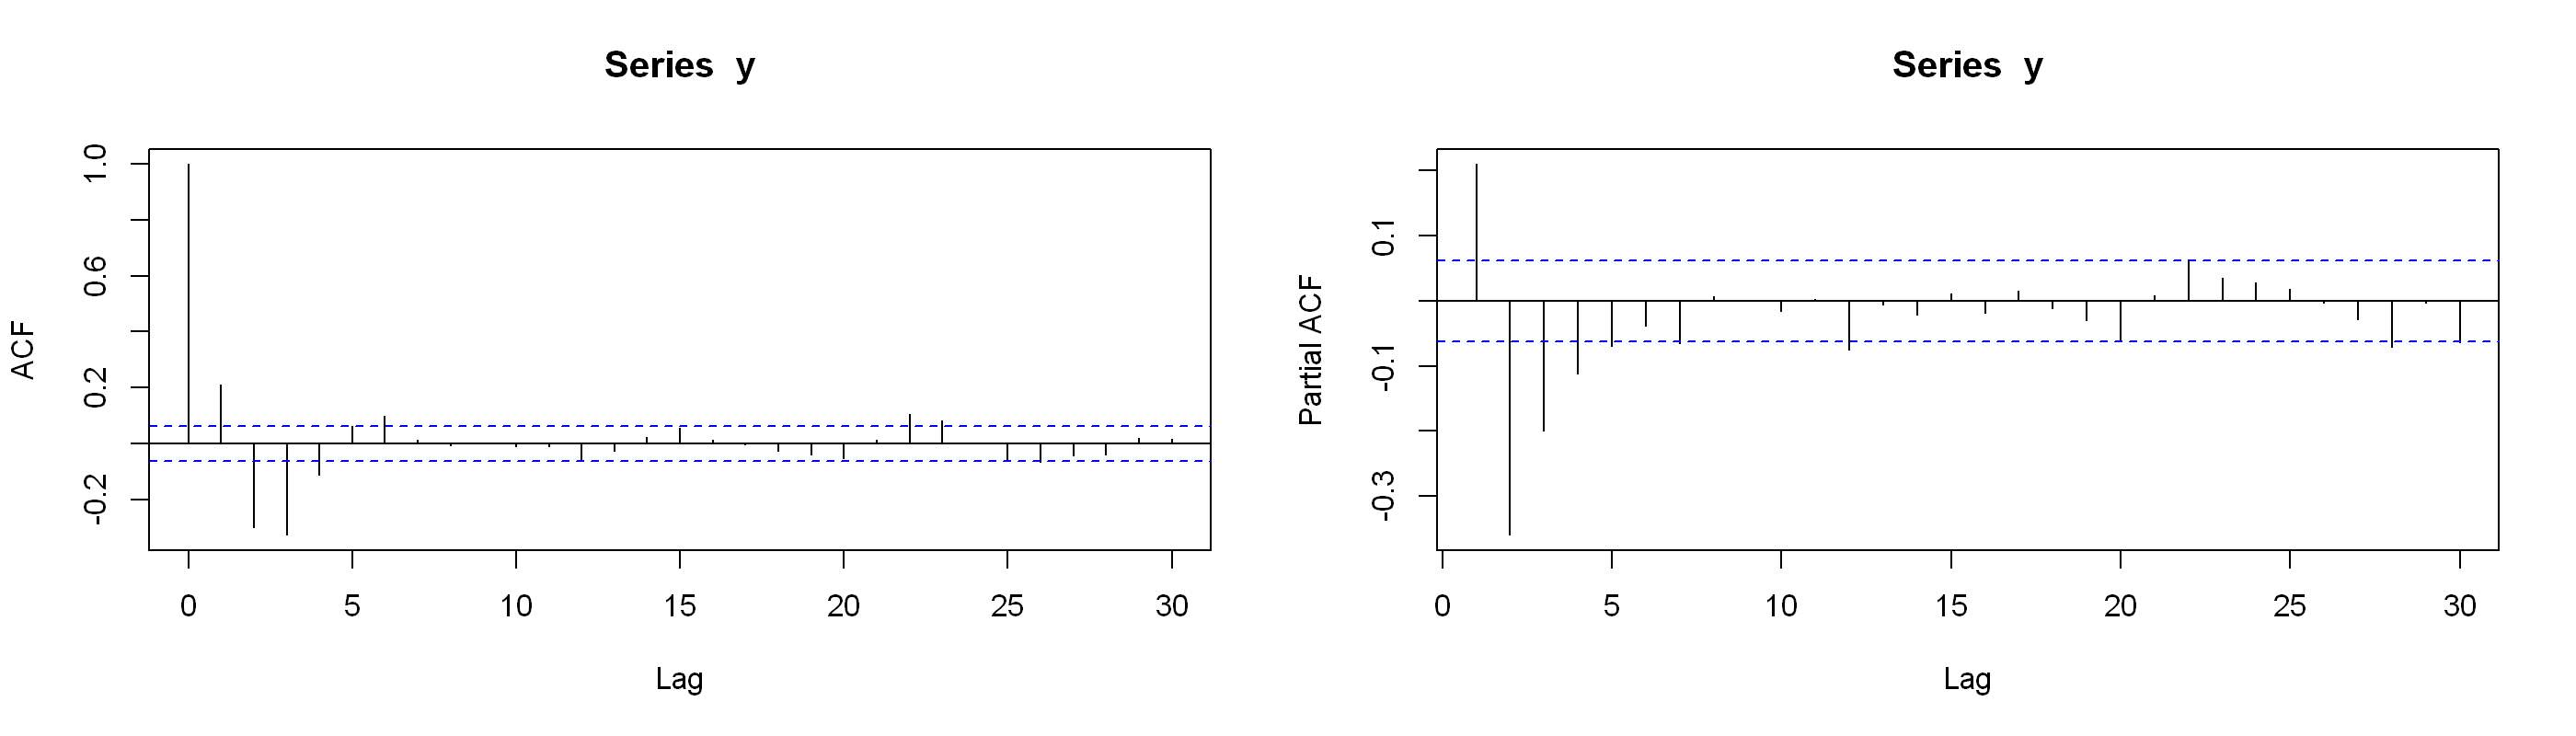

In [74]:
par(bg = 'white', mfrow = c(1, 2))
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 200)
acf(y)
pacf(y)

MA(q) = lag 1, 2, 3, 4
AR(p) = lab 1, 2, 3, 4

In [75]:
ar1.ma1.model = arima(y, order = c(1, 0, 1))
ar1.ma1.model


Call:
arima(x = y, order = c(1, 0, 1))

Coefficients:
          ar1     ma1  intercept
      -0.1881  0.4988    -0.0027
s.e.   0.0685  0.0573     0.0434

sigma^2 estimated as 1.183:  log likelihood = -1502.99,  aic = 3013.98

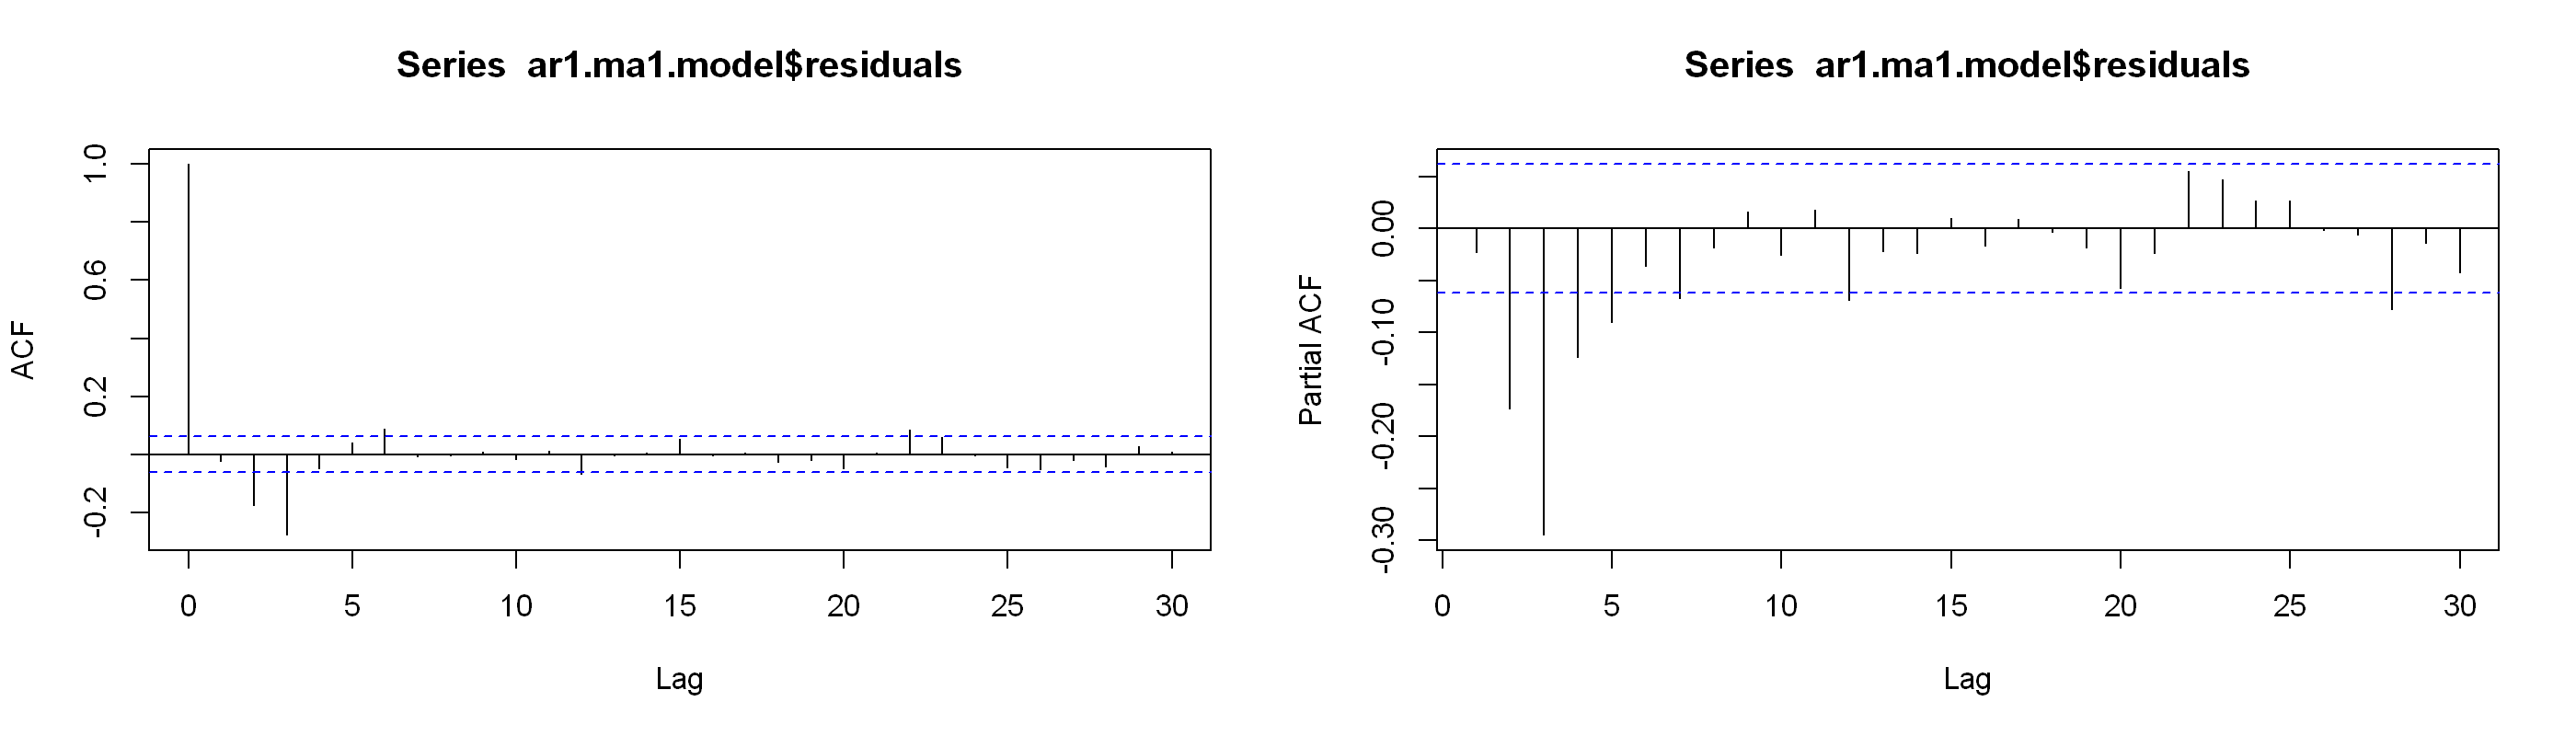

In [76]:
par(bg = 'white', mfrow = c(1, 2))
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 200)
acf(ar1.ma1.model$residuals)
pacf(ar1.ma1.model$residuals)

In [77]:
ar2.ma1.model = arima(y, order = c(2, 0, 1))
ar2.ma1.model


Call:
arima(x = y, order = c(2, 0, 1))

Coefficients:
         ar1      ar2      ma1  intercept
      0.7850  -0.4623  -0.6127    -0.0052
s.e.  0.0487   0.0285   0.0522     0.0183

sigma^2 estimated as 1.016:  log likelihood = -1427.16,  aic = 2864.33

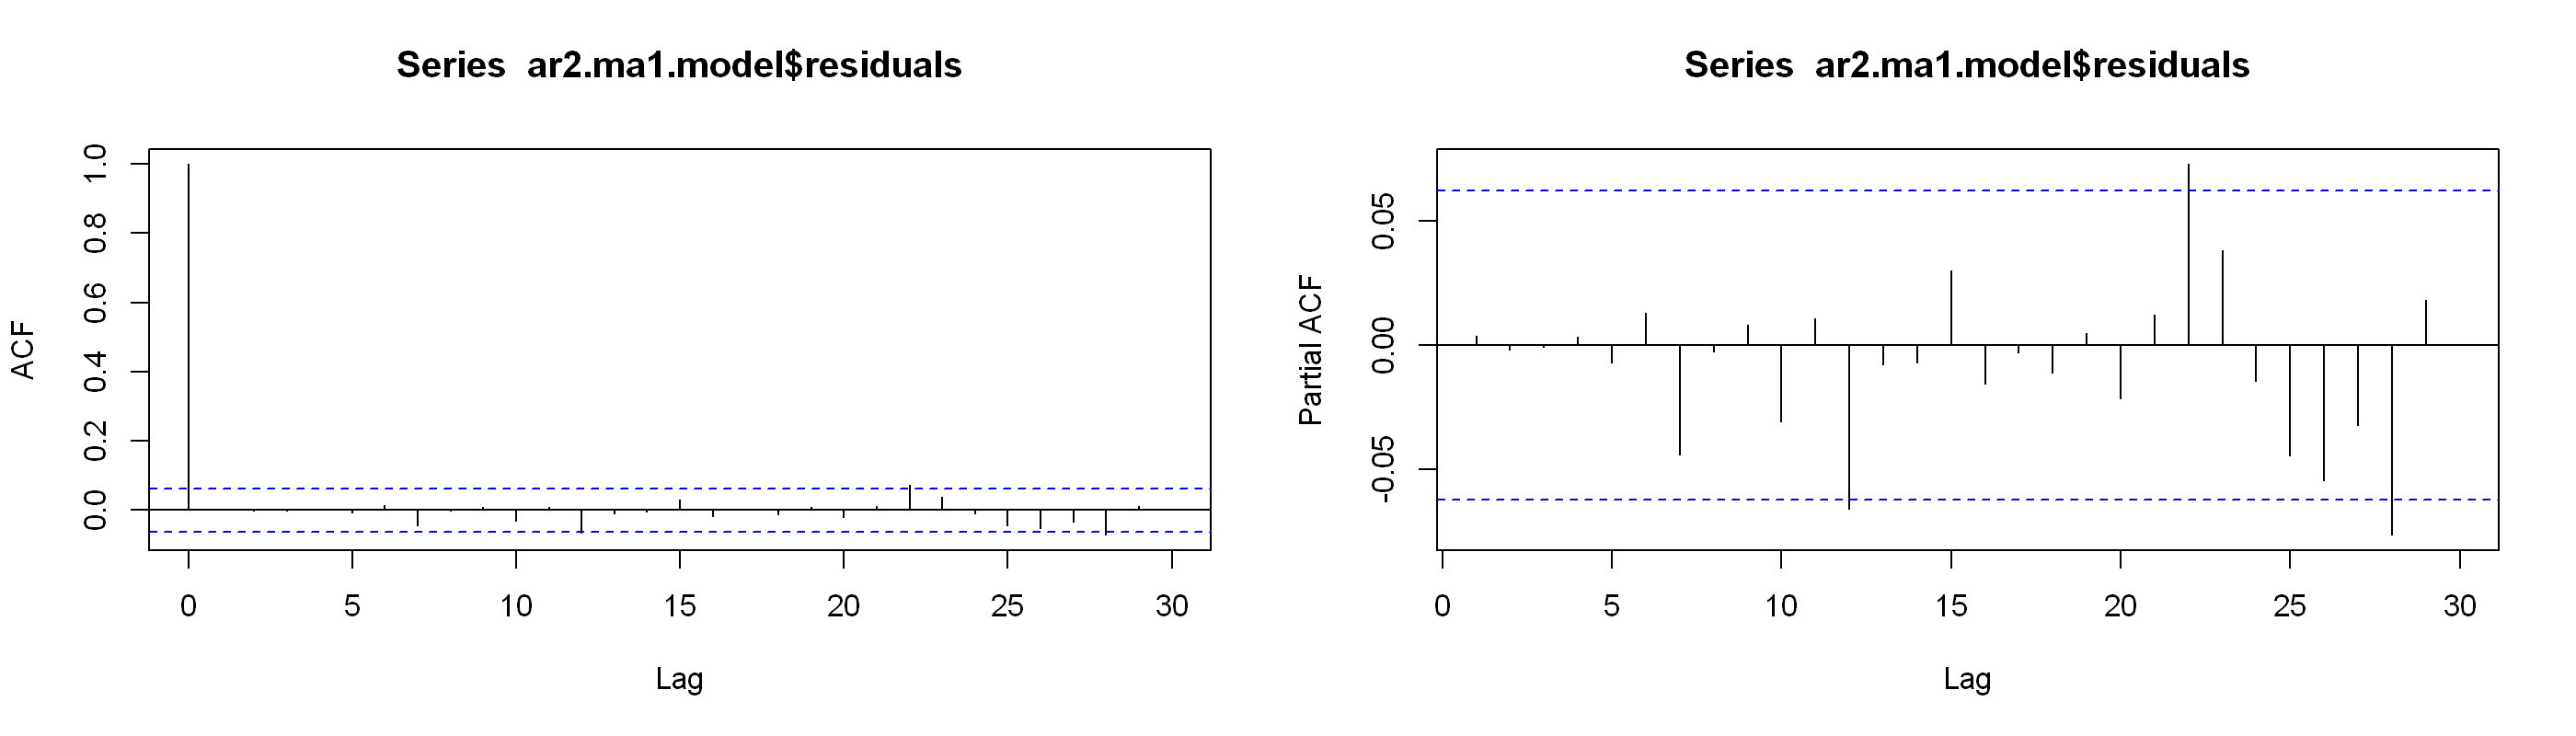

In [78]:
par(bg = 'white', mfrow = c(1, 2))
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 200)
acf(ar2.ma1.model$residuals)
pacf(ar2.ma1.model$residuals)


Call:
arima(x = y, order = c(2, 0, 2))

Coefficients:
         ar1      ar2      ma1      ma2  intercept
      0.7708  -0.4410  -0.5954  -0.0274    -0.0053
s.e.  0.0607   0.0619   0.0672   0.0697     0.0180

sigma^2 estimated as 1.016:  log likelihood = -1427.09,  aic = 2866.17

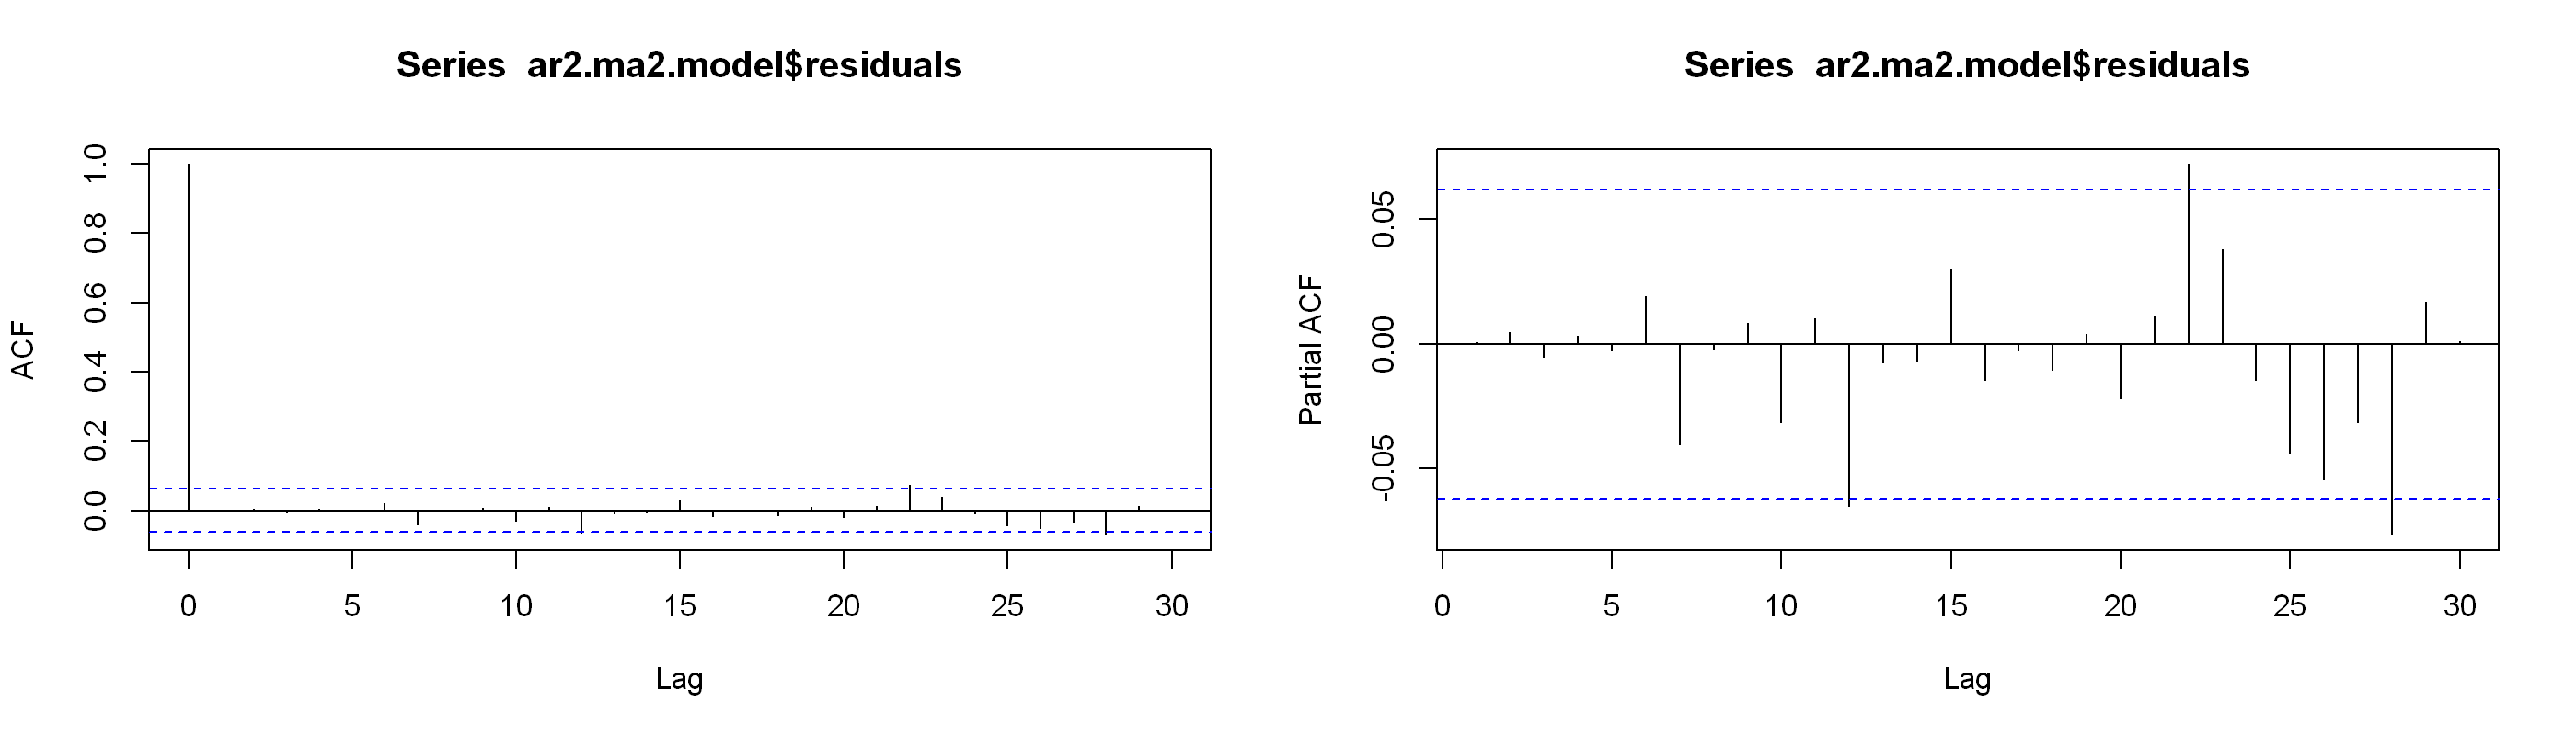

In [79]:
ar2.ma2.model = arima(y, order = c(2, 0, 2))
ar2.ma2.model


par(bg = 'white', mfrow = c(1, 2))
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 200)
acf(ar2.ma2.model$residuals)
pacf(ar2.ma2.model$residuals)


Call:
arima(x = y, order = c(2, 1, 2))

Coefficients:
         ar1      ar2      ma1     ma2
      0.7857  -0.4617  -1.6111  0.6115
s.e.  0.0489   0.0285   0.0531  0.0528

sigma^2 estimated as 1.018:  log likelihood = -1430.24,  aic = 2870.49

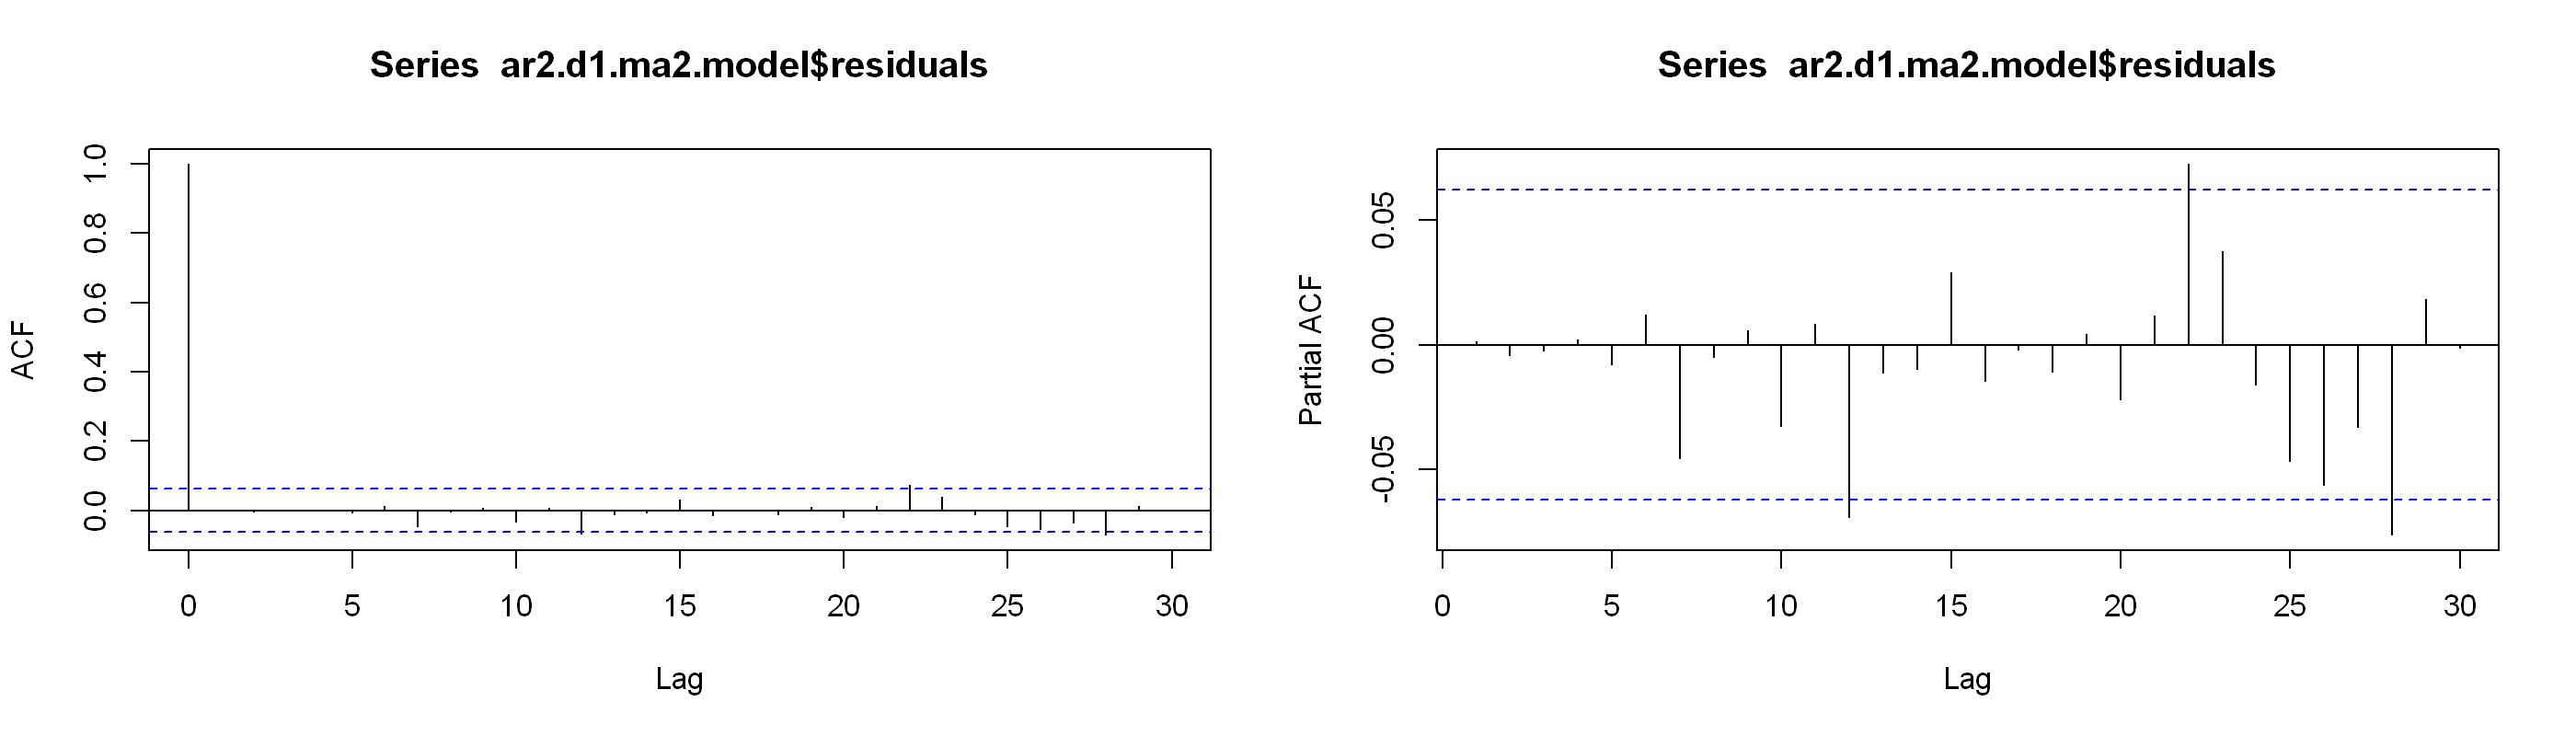

In [80]:
ar2.d1.ma2.model = arima(y, order = c(2, 1, 2))
ar2.d1.ma2.model


par(bg = 'white', mfrow = c(1, 2))
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 200)
acf(ar2.d1.ma2.model$residuals)
pacf(ar2.d1.ma2.model$residuals)

> Maneria manual é complexa.

#### Ajustando automaticamente

In [81]:
est.auto = auto.arima(data$`Banking orders (2)`, max.p = 3, max.q = 9, stepwise = FALSE)
est.auto

Series: data$`Banking orders (2)` 
ARIMA(0,0,3) with non-zero mean 

Coefficients:
          ma1      ma2      ma3       mean
      -0.0645  -0.1144  -0.4796  79914.783
s.e.   0.1327   0.1150   0.1915   1897.407

sigma^2 = 1.467e+09:  log likelihood = -716.71
AIC=1443.42   AICc=1444.53   BIC=1453.89

In [82]:
auto.model = auto.arima(y)
auto.model

Series: y 
ARIMA(2,0,1) with zero mean 

Coefficients:
         ar1      ar2      ma1
      0.7847  -0.4622  -0.6123
s.e.  0.0487   0.0285   0.0522

sigma^2 = 1.019:  log likelihood = -1427.21
AIC=2862.41   AICc=2862.45   BIC=2882.04

### Variações